## 1. Import Library

In [1]:
# Cell 1: import & helper MFs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})

## 2. Definisi Membership Function (sesuai rumus artikel)

In [2]:
def mu_kurus(x):
    if x < 5: return 1.0
    if 5 <= x <= 9: return (9.0 - x) / (9.0 - 5.0)
    return 0.0

def mu_normal(x):
    if x <= 5 or x >= 20: return 0.0
    if 5 <= x <= 9: return (x - 5.0) / (9.0 - 5.0)
    if 9 <= x <= 20: return (20.0 - x) / (20.0 - 9.0)
    return 0.0

def mu_sedang_imt(x):
    if x <= 9 or x >= 25: return 0.0
    if 9 <= x <= 20: return (x - 9.0) / (20.0 - 9.0)
    if 20 <= x <= 25: return (25.0 - x) / (25.0 - 20.0)
    return 0.0

def mu_gemuk(x):
    if x < 20: return 0.0
    if 20 <= x <= 25: return (x - 20.0) / (25.0 - 20.0)
    return 1.0

# PHQ MFs
def mu_rendah_phq(x):
    if x < 10: return 1.0
    if 10 <= x <= 15: return (15.0 - x) / (15.0 - 10.0)
    return 0.0

def mu_sedang_phq(x):
    if x <= 10 or x >= 25: return 0.0
    if 10 <= x <= 15: return (x - 10.0) / (15.0 - 10.0)
    if 15 <= x <= 25: return (25.0 - x) / (25.0 - 15.0)
    return 0.0

def mu_tinggi_phq(x):
    if x < 15: return 0.0
    if 15 <= x <= 25: return (x - 15.0) / (25.0 - 15.0)
    return 1.0

# small helper to vectorize easily
v_kurus = np.vectorize(mu_kurus)
v_normal = np.vectorize(mu_normal)
v_sedang_imt = np.vectorize(mu_sedang_imt)
v_gemuk = np.vectorize(mu_gemuk)

v_rendah = np.vectorize(mu_rendah_phq)
v_sedang_phq = np.vectorize(mu_sedang_phq)
v_tinggi_phq = np.vectorize(mu_tinggi_phq)

## 3. Definisi Rule Base (referensi artikel) dan Fungsi Fuzzifikasi

In [3]:
# RULES: (imt_label, phq_label, z_value, label_name)
RULES = [
    ('kurus','rendah', 0, 'Tidak Depresi'),
    ('normal','rendah', 0, 'Tidak Depresi'),
    ('sedang','rendah', 21, 'Ringan'),
    ('gemuk','rendah', 21, 'Ringan'),
    ('kurus','sedang', 43, 'Sedang'),
    ('normal','sedang', 21, 'Ringan'),
    ('sedang','sedang', 43, 'Sedang'),
    ('gemuk','sedang', 43, 'Sedang'),
    ('kurus','tinggi', 43, 'Sedang'),
    ('normal','tinggi', 43, 'Sedang'),
    ('sedang','tinggi', 63, 'Berat'),
    ('gemuk','tinggi', 63, 'Berat')
]

def compute_memberships(imt, phq):
    imt_mfs = {
        'kurus': mu_kurus(imt),
        'normal': mu_normal(imt),
        'sedang': mu_sedang_imt(imt),
        'gemuk': mu_gemuk(imt)
    }
    phq_mfs = {
        'rendah': mu_rendah_phq(phq),
        'sedang': mu_sedang_phq(phq),
        'tinggi': mu_tinggi_phq(phq)
    }
    return imt_mfs, phq_mfs

def evaluate_rules(imt, phq, verbose=False):
    imt_mfs, phq_mfs = compute_memberships(imt, phq)
    activations = []
    for i, (im_label, ph_label, zval, lname) in enumerate(RULES, start=1):
        alpha = min(imt_mfs[im_label], phq_mfs[ph_label])
        activations.append({'rule': f'R{i}', 'imt':im_label, 'phq':ph_label,
                            'alpha': alpha, 'z': zval, 'label': lname})
    if verbose:
        print("IMT memberships:", imt_mfs)
        print("PHQ memberships:", phq_mfs)
        for a in activations:
            if a['alpha']>0:
                print(f"{a['rule']}: IF IMT {a['imt']} AND PHQ {a['phq']} -> alpha={a['alpha']:.4f}, z={a['z']}, label={a['label']}")
    return activations


## 4. Sugeno Defuzzification + Visualisasi Aktivasi & Kontribusi

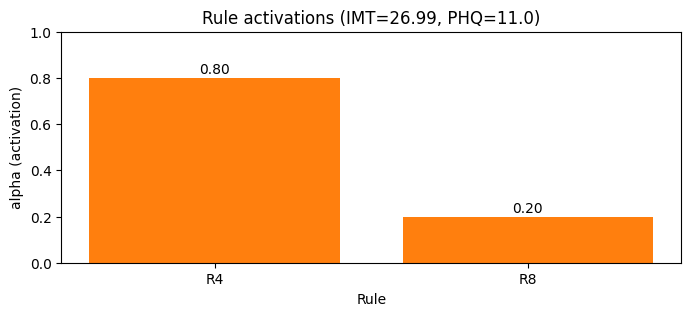

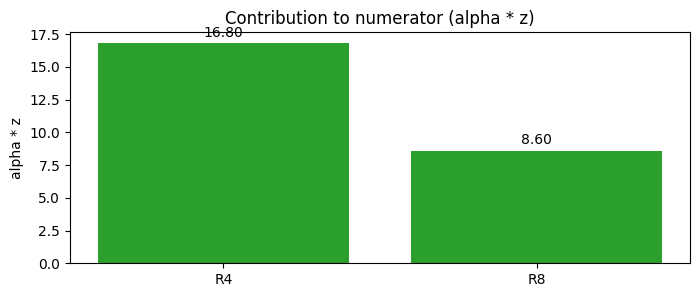

Sugeno weighted average result: Z = 25.4000


In [4]:
def sugeno_defuzz(imt, phq, plot=True):
    acts = evaluate_rules(imt, phq)
    # keep only triggered
    triggered = [a for a in acts if a['alpha']>0]
    if len(triggered)==0:
        Z = 0.0
    else:
        num = sum(a['alpha']*a['z'] for a in triggered)
        den = sum(a['alpha'] for a in triggered)
        Z = num/den

    # build a dataframe for presentation
    df = pd.DataFrame(triggered)
    if plot:
        # bar: activation degrees
        plt.figure(figsize=(8,3))
        plt.bar(df['rule'], df['alpha'], color='C1')
        plt.ylim(0,1)
        plt.title(f'Rule activations (IMT={imt}, PHQ={phq})')
        plt.xlabel('Rule')
        plt.ylabel('alpha (activation)')
        for i, v in enumerate(df['alpha']):
            plt.text(i, v+0.02, f"{v:.2f}", ha='center')
        plt.show()

        # contributions to numerator (alpha*z)
        plt.figure(figsize=(8,3))
        contrib = df['alpha'] * df['z']
        plt.bar(df['rule'], contrib, color='C2')
        plt.title('Contribution to numerator (alpha * z)')
        plt.ylabel('alpha * z')
        for i, v in enumerate(contrib):
            plt.text(i, v+0.5, f"{v:.2f}", ha='center')
        plt.show()

        print(f"Sugeno weighted average result: Z = {Z:.4f}")
    return Z, df

# Quick demo with Pegawai 1 (IMT=26.99, PHQ=11)
Z1, df1 = sugeno_defuzz(26.99, 11.0, plot=True)


## 5. Mamdani Demonstration (create output MFs, clip by activations, aggregate, centroid)

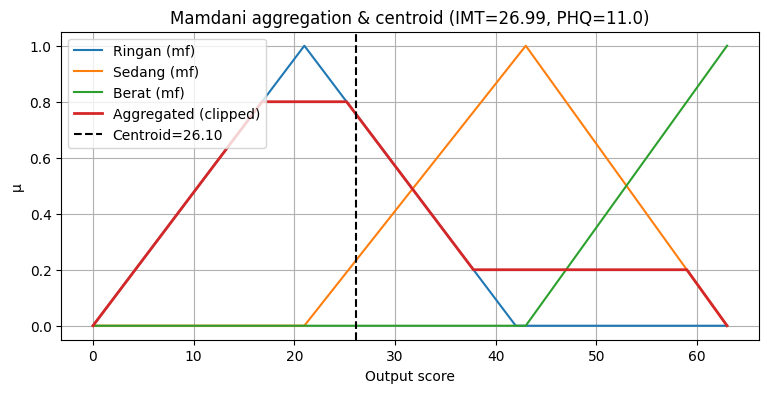

Mamdani centroid result: 26.0970 (numer=6362.4533, denom=243.8000)


In [5]:
# We'll define output universe 0..63 (as per max z value in article)
out_u = np.linspace(0,63,631)  # fine grid for centroid

# Define Mamdani output MFs around labels (roughly centered at 0,21,43,63)
def out_tidak(x):
    # triangular near 0 (0..0..10)
    a,b,c = 0.0, 0.0, 10.0
    return max(0.0, min((x-a)/(b-a+1e-9) if b!=a else 1.0, (c-x)/(c-b+1e-9)))

def out_ringan_arr(x_arr):
    # triangle peak ~21
    return np.maximum(0, np.minimum((x_arr-0)/(21-0+1e-9), (42-x_arr)/(42-21+1e-9)))  # broader shape

def out_sedang_arr(x_arr):
    # triangle peak ~43
    return np.maximum(0, np.minimum((x_arr-21)/(43-21+1e-9), (63-x_arr)/(63-43+1e-9)))

def out_berat_arr(x_arr):
    # right trapezoid near top
    arr = np.zeros_like(x_arr)
    # linear rise from 43 to 63
    idx = (x_arr>=43) & (x_arr<=63)
    arr[idx] = (x_arr[idx]-43)/(63-43)
    idx2 = x_arr>63
    arr[idx2] = 1.0
    return arr

# Vectorized versions
out_ringan = out_ringan_arr(out_u)
out_sedang = out_sedang_arr(out_u)
out_berat = out_berat_arr(out_u)
out_tidak_vec = np.array([out_tidak(x) for x in out_u])

def mamdani_defuzz(imt, phq, plot=True):
    acts = evaluate_rules(imt, phq)
    triggered = [a for a in acts if a['alpha']>0]
    # init aggregated output
    agg = np.zeros_like(out_u)
    # map rule consequents to mamdani MFs: we use label to decide
    for a in triggered:
        lab = a['label']
        alpha = a['alpha']
        if lab == 'Tidak Depresi':
            clipped = np.minimum(alpha, out_tidak_vec)
        elif lab == 'Ringan':
            clipped = np.minimum(alpha, out_ringan)
        elif lab == 'Sedang':
            clipped = np.minimum(alpha, out_sedang)
        elif lab == 'Berat':
            clipped = np.minimum(alpha, out_berat)
        else:
            clipped = np.zeros_like(out_u)
        agg = np.maximum(agg, clipped)

    # centroid
    numer = np.sum(agg * out_u)
    denom = np.sum(agg) + 1e-12
    centroid = numer / denom if denom>0 else 0.0

    if plot:
        plt.figure(figsize=(9,4))
        plt.plot(out_u, out_ringan, label='Ringan (mf)')
        plt.plot(out_u, out_sedang, label='Sedang (mf)')
        plt.plot(out_u, out_berat, label='Berat (mf)')
        plt.plot(out_u, agg, linewidth=2, label='Aggregated (clipped)')
        plt.axvline(centroid, color='k', linestyle='--', label=f'Centroid={centroid:.2f}')
        plt.title(f'Mamdani aggregation & centroid (IMT={imt}, PHQ={phq})')
        plt.xlabel('Output score')
        plt.ylabel('μ')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Mamdani centroid result: {centroid:.4f} (numer={numer:.4f}, denom={denom:.4f})")
    return centroid, agg

# Demo Mamdani for same Pegawai 1
centroid1, agg1 = mamdani_defuzz(26.99, 11.0, plot=True)


## 6. Hasil Ringkasan Visualisasi Keseluruhan Karyawan + Plot Batang Keanggotaan Pembungkus


=== Pegawai 1 : IMT=26.99, PHQ=11 ===


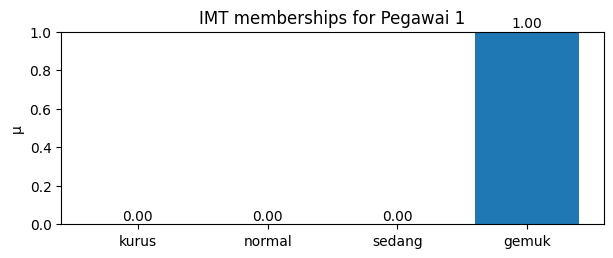

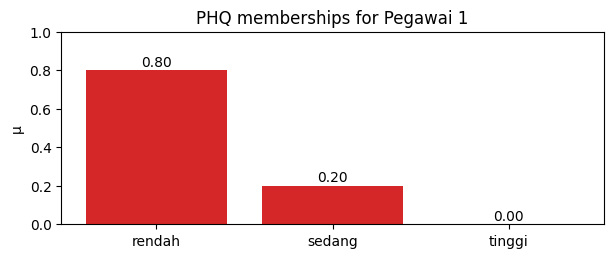

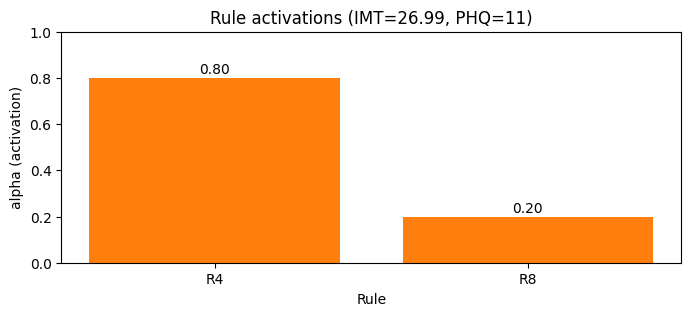

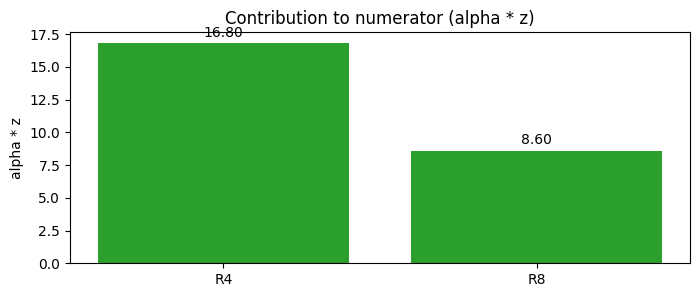

Sugeno weighted average result: Z = 25.4000


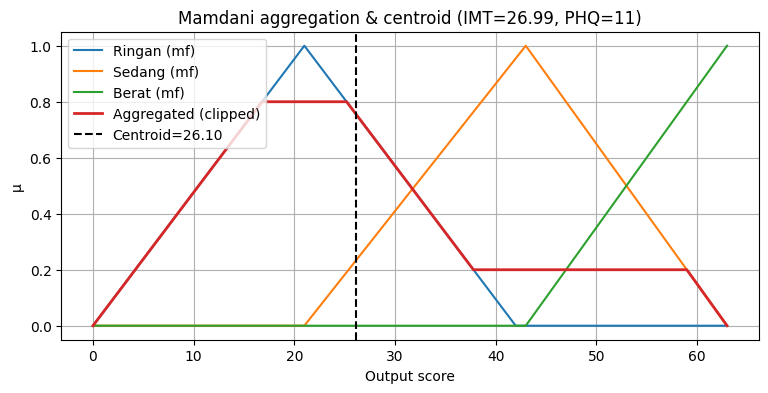

Mamdani centroid result: 26.0970 (numer=6362.4533, denom=243.8000)
 Sugeno Z = 25.400 -> Sedang
 Mamdani centroid = 26.097 -> Sedang

=== Pegawai 23 : IMT=23.53, PHQ=18 ===


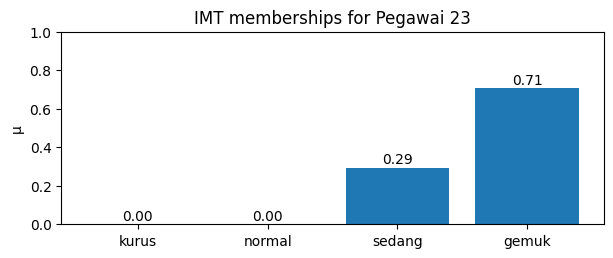

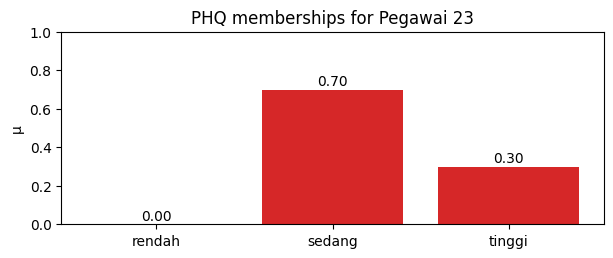

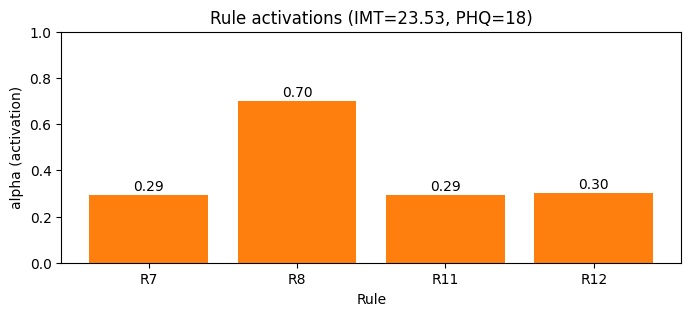

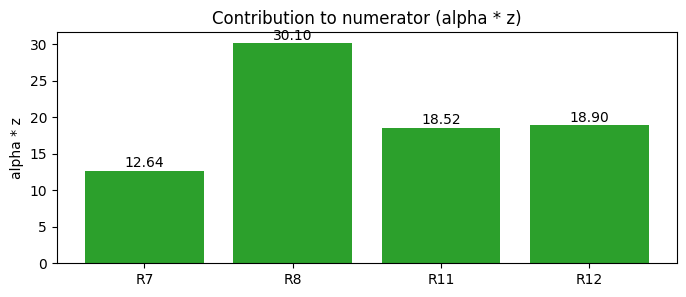

Sugeno weighted average result: Z = 50.4811


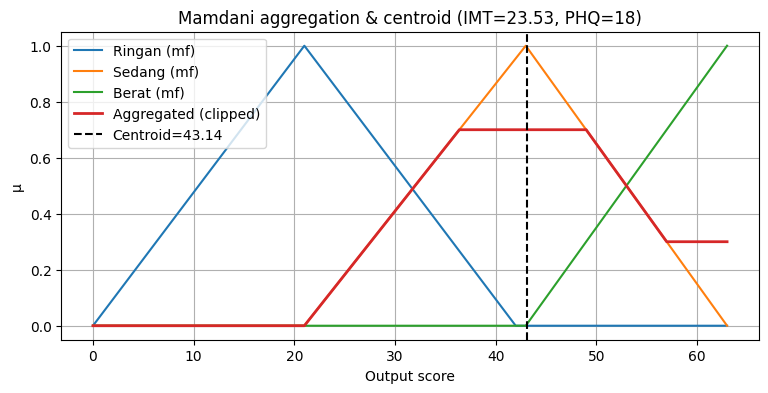

Mamdani centroid result: 43.1437 (numer=8639.5350, denom=200.2500)
 Sugeno Z = 50.481 -> Berat
 Mamdani centroid = 43.144 -> Berat

=== Pegawai 37 : IMT=20.7, PHQ=9 ===


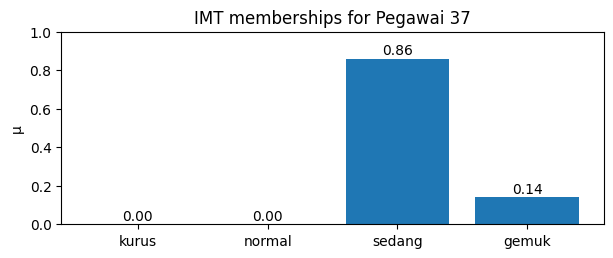

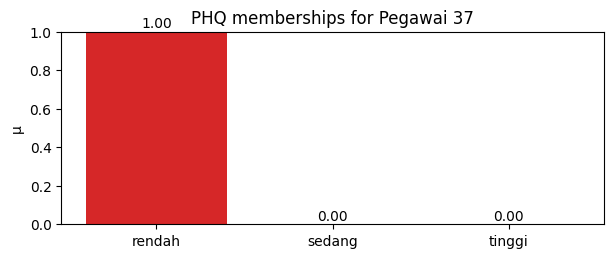

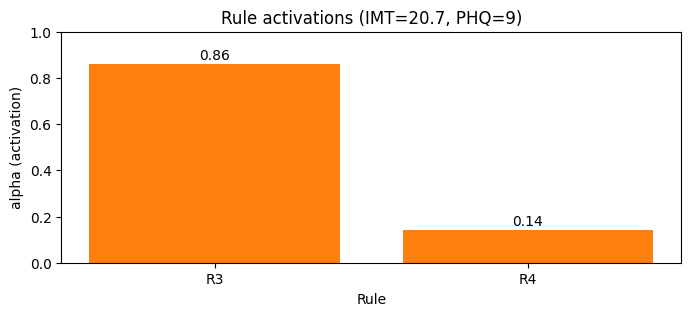

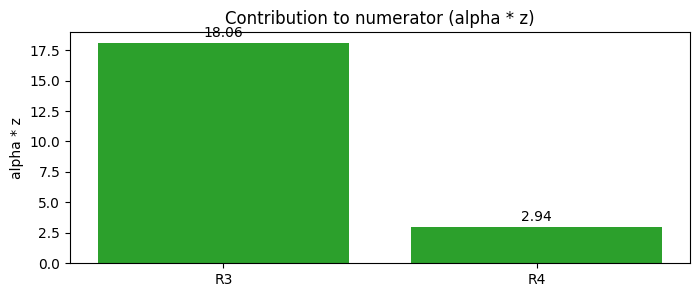

Sugeno weighted average result: Z = 21.0000


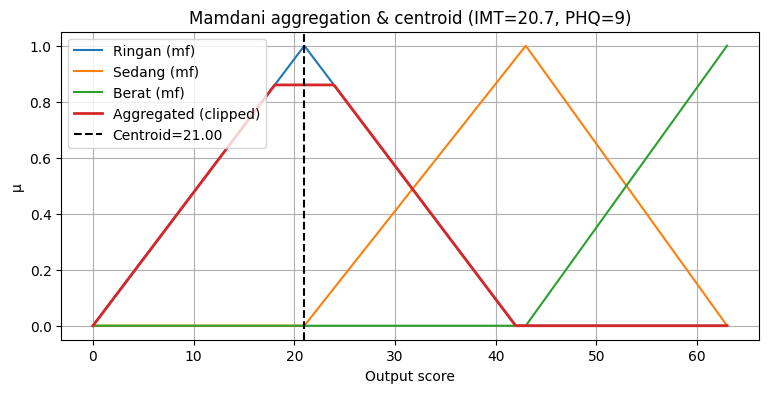

Mamdani centroid result: 21.0000 (numer=4323.5400, denom=205.8829)
 Sugeno Z = 21.000 -> Ringan
 Mamdani centroid = 21.000 -> Ringan


In [6]:
def run_and_show(imt, phq, name="Employee"):
    print(f"\n=== {name} : IMT={imt}, PHQ={phq} ===")
    # show input memberships (bar charts)
    imt_mfs, phq_mfs = compute_memberships(imt, phq)
    imt_labels = list(imt_mfs.keys())
    phq_labels = list(phq_mfs.keys())
    imt_vals = list(imt_mfs.values())
    phq_vals = list(phq_mfs.values())

    plt.figure(figsize=(7,2.5))
    plt.bar(imt_labels, imt_vals, color='C0')
    plt.ylim(0,1); plt.title(f'IMT memberships for {name}'); plt.ylabel('μ')
    for i,v in enumerate(imt_vals): plt.text(i, v+0.02, f"{v:.2f}", ha='center')
    plt.show()

    plt.figure(figsize=(7,2.5))
    plt.bar(phq_labels, phq_vals, color='C3')
    plt.ylim(0,1); plt.title(f'PHQ memberships for {name}'); plt.ylabel('μ')
    for i,v in enumerate(phq_vals): plt.text(i, v+0.02, f"{v:.2f}", ha='center')
    plt.show()

    # Sugeno
    Z, df = sugeno_defuzz(imt, phq, plot=True)
    # Mamdani
    centroid, agg = mamdani_defuzz(imt, phq, plot=True)

    # Map to categories (consistent with earlier mapping)
    def map_label_sugeno(Zv):
        if Zv == 0: return "Tidak Depresi"
        if Zv <= 21: return "Ringan"
        if Zv <= 43: return "Sedang"
        return "Berat"

    print(f" Sugeno Z = {Z:.3f} -> {map_label_sugeno(Z)}")
    print(f" Mamdani centroid = {centroid:.3f} -> {map_label_sugeno(centroid)}")

# Run for the 3 examples from article
examples = [
    ("Pegawai 1", 26.99, 11),
    ("Pegawai 23", 23.53, 18),
    ("Pegawai 37", 20.70, 9)
]

for name, imt, phq in examples:
    run_and_show(imt, phq, name)
